# TFM - Generación de diálogos creativos entre personajes virtuales

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [3]:
# Imports

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange
import torch

from pathlib import Path

import huggingface_hub

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

## Tomamos los datos

### Dataset tomado de: https://github.com/srobz/How-I-Analyzed-Your-Mother (Todo el crédito para su trabajo de creación del dataset)

In [4]:
data = pd.read_csv('HIMYM.csv')

In [5]:
data

,Season,Episode,Character,Line
0,1,1,Marshall,(Opens ring) Will you marry me.
1,1,1,Ted,"Yes, perfect! And then you're engaged, you pop..."
2,1,1,Marshall,"Got it. Thanks for helping me plan this out, Ted."
3,1,1,Ted,"Dude, are you kidding? It's you and Lily! I've..."
4,1,1,Marshall,"(laughs) yeah, sorry. We thought you were asleep."
...,...,...,...,...
22779,8,24,Marshall,It is so much fun.
22780,8,24,Marshall,I love crushed nuts.
22781,8,24,Barney,"""I'm probably saying some political stuff righ..."
22782,8,24,Barney,Whoa. Is there going to be a fight?


In [6]:
#Como hay expresiones con paréntesis (del guión), elimino todas las expresiones entre paréntesis

# Función para eliminar expresiones entre paréntesis
def eliminar_expresiones(texto):
    return re.sub(r'\([^)]*\)', '', texto)

# Aplicar la función a la columna 'line'
data['Line'] = data['Line'].apply(eliminar_expresiones)

In [7]:
data

,Season,Episode,Character,Line
0,1,1,Marshall,Will you marry me.
1,1,1,Ted,"Yes, perfect! And then you're engaged, you pop..."
2,1,1,Marshall,"Got it. Thanks for helping me plan this out, Ted."
3,1,1,Ted,"Dude, are you kidding? It's you and Lily! I've..."
4,1,1,Marshall,"yeah, sorry. We thought you were asleep."
...,...,...,...,...
22779,8,24,Marshall,It is so much fun.
22780,8,24,Marshall,I love crushed nuts.
22781,8,24,Barney,"""I'm probably saying some political stuff righ..."
22782,8,24,Barney,Whoa. Is there going to be a fight?


In [8]:
CHARACTER_NAME = 'Barney'

In [9]:
contexted = []

# Cogemos las 7 lines anteriores como contexto
n = 7


# Tomamos solo las líneas de Barney (como principales, como contexto tomamos las de todos)
for i in data[data.Character == CHARACTER_NAME].index:
    if i < n:
        continue
    row = []
    current_episode = data.Episode[i]
    prev = i - 1 - n  # restamos 1 para que la fila contenga la respuesta actual y las 7 respuestas anteriores
    for j in range(i, prev, -1):
        if data.Episode[j] == current_episode:
            row.append(data.Line[j])
        else:
            # Si la línea no pertenece al mismo episodio, dejamos de agregar al contexto
            break
    contexted.append(row)

columns = ['response', 'context']
columns = columns + ['context/' + str(i) for i in range(n - 1)]

df = pd.DataFrame.from_records(contexted, columns=columns)

# Rellenar las celdas vacías con una cadena vacía
df = df.fillna('')

In [10]:
df

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,"hey, so you know how I've always had a thing ...","Yeah, what are you doing tonight?","It's physics Marshall, if the bottom bunk move...","yeah, sorry. We thought you were asleep.","Dude, are you kidding? It's you and Lily! I've...","Got it. Thanks for helping me plan this out, Ted.","Yes, perfect! And then you're engaged, you pop...",Will you marry me.
1,"Okay, meet me at the bar in fifteen minutes, a...","Hey, you wanna do something tonight?","hey, so you know how I've always had a thing ...","Yeah, what are you doing tonight?","It's physics Marshall, if the bottom bunk move...","yeah, sorry. We thought you were asleep.","Dude, are you kidding? It's you and Lily! I've...","Got it. Thanks for helping me plan this out, Ted."
2,Where's your suit!? Just once when I say suit ...,Hey.,"Okay, meet me at the bar in fifteen minutes, a...","Hey, you wanna do something tonight?","hey, so you know how I've always had a thing ...","Yeah, what are you doing tonight?","It's physics Marshall, if the bottom bunk move...","yeah, sorry. We thought you were asleep."
3,It was a blazer!,I did that one time.,Where's your suit!? Just once when I say suit ...,Hey.,"Okay, meet me at the bar in fifteen minutes, a...","Hey, you wanna do something tonight?","hey, so you know how I've always had a thing ...","Yeah, what are you doing tonight?"
4,I see what this is about. Have you forgotten w...,"You know, ever since college it's been Marshal...",It was a blazer!,I did that one time.,Where's your suit!? Just once when I say suit ...,Hey.,"Okay, meet me at the bar in fifteen minutes, a...","Hey, you wanna do something tonight?"
...,...,...,...,...,...,...,...,...
4772,The Ho-be-gone Sleep System,,,,,,,
4773,"Ted, wait.",The Ho-be-gone Sleep System,,,,,,
4774,"Mind-blowing entertainment, like a naked fire ...",,,,,,,
4775,"""I'm probably saying some political stuff righ...",I love crushed nuts.,It is so much fun.,,,,,


In [11]:
#Hacemos el split en train y validation
trn_df, val_df = train_test_split(df, test_size=0.1, shuffle=True)
trn_df

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
3246,"Once I have his attention, it's time to get ou...","Wait, Ted. Listen to the man.",Are you kidding me.,Of course not.,I do not even know why we laugh!,It's because you're a woman.,Thank you explained that. I get confused easily.,"Exactly! Similarly, if you do not like having ..."
2610,Guess who is not lactose intolerant: Tyler. Ty...,Go and eat your ice.,You can stop with that?,"Come on, Barney. You have no idea of the diffi...",No weak link in this scene. Bravo!,We're a happy family.,"Tyler said: ""In my nightmare, mom and you did ...","Thank you very much, man. Tonight I will not s..."
1533,Let me illustrate.,"Wait, hot-crazy scale?",She's not even on the hot-crazy scale. She's j...,There's no way she's above the line on the hot...,"OK, she's not crazy, she's not a hooker, she's...","Ted, the only hot girls that troll the Interne...",No she's not.,Then she's crazy.
3873,"Of course, of course.",I really have to get this done.,"Correct. What lightweight outfit, pink or whit...",A sun dress.,"I'm sorry. I'll let you work. But first, a rid...","Barney, I really... I have to grade these papers.","Look at your beer, dude. You always do that wh...",What? No. I'm just hoping it doesn't rain. Why...
4045,"And what did this ""Zoey"" say when she found ou...",This isn't about the girl. It's about the buil...,"Hmm. Grape scotch. Not bad. Ted, you only thin...",Where do I sign?,And you said...?,Anything.,"Oh, Ted, that's so romantic. I want to fill a ...","Well, I'd say you got a pretty long wait."
...,...,...,...,...,...,...,...,...
2602,The nostrils dilated. They do it when she gets...,What kind?,Just a little script. Things that my mother wi...,Wait. You wrote that we will have dinner?,I can make another cast. Will remember your se...,We talked about it a million times! You get no...,You know what? I hate you!,Really? I hate your mother.
2732,There is no softball team. We just rented a fi...,When you played third base for the softball te...,Is there anything else you want to tell me?,"No, it's not good! Damn, you're in the working...",Louisa. What can we do about it? Do not like y...,All right!,Good job.,Wait. It explains what happened to Louisa.
435,"Oh, Tanya, I'm so glad you said that.","Yeah, I ship out tomorrow for two years. You k...",,,,,,
1046,I hate you!,No!,But my throat hurts.,"No, you're not having ice cream for dinner jus...",Ouchie in my mouth! I don't want it. I want ic...,"Fine, I'll feed you.",Too weak... to hold... bowl.,"Come on, you need eat something."


In [12]:
# Creamos un dataset adecuado a nuestro modelo

# Esta función toma una fila de un DataFrame (row), un tokenizador (tokenizer), y un parámetro opcional eos (end of sentence), que es True por defecto.
# La función primero invierte la lista de oraciones (row).
# Luego, tokeniza cada oración usando el tokenizador, agrega el token de fin de oración (EOS) al final y los concatena en una lista.
# La función devuelve una lista plana (conv) de los tokens de las oraciones en el orden invertido.

def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        # Se ajusta el block_size para tener en cuenta la longitud máxima del modelo y la longitud máxima de una sola oración según el tokenizador.
        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)


        # Se verifica si ya existen características en caché en un archivo específico y se cargan si es así, a menos que se indique explícitamente sobrescribir la caché (args.overwrite_cache).
        # Si no hay características en caché o se elige sobrescribir, se construyen las características del conjunto de datos.
        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            print("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            print("Creating features from dataset file at %s", directory)


            # Para cada fila del DataFrame (df), se llama a la función construct_conv para obtener la lista de tokens (conv) y se agrega a self.examples.
            # Las características construidas se guardan en caché para un acceso más rápido en el futuro.
            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            print("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # Añadir atributo "labels"
        self.labels = []
        for _, row in df.iterrows():
            label = construct_conv([row[0]], tokenizer)  # Tomar solo la primera columna como label
            self.labels.append(label)

        # Añadir atributo "features"
        self.features = self.examples  # Utilizar las conversaciones tokenizadas como features

    # Devuelve la longitud del conjunto de datos, es decir, la cantidad de ejemplos.
    def __len__(self):
        return len(self.examples)

    # Devuelve un ejemplo del conjunto de datos en la posición item como un tensor de tipo largo (torch.tensor).
    # El ejemplo es la representación tokenizada de una conversación (la lista plana de tokens obtenida de construct_conv).
    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [13]:
#Creamos ahora el manejo de los puntos de control y su control en el caché.

# Función para cargar y almacenar ejemplos en caché
def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    # Retorna un objeto de la clase ConversationDataset, que maneja la construcción del conjunto de datos
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

# Función para fijar la semilla para la reproducibilidad
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

# Función para obtener la lista de puntos de control (checkpoints) ordenados
def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    # Busca todos los archivos que coincidan con el prefijo de los puntos de control
    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    # Para cada archivo, recopila el tiempo de modificación (si se usa) y la ruta del punto de control
    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    # Ordena los puntos de control según el tiempo de modificación o el número en el nombre
    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted

# Función para rotar (eliminar) puntos de control antiguos si se alcanza el límite de almacenamiento total
def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Verifica si se debe eliminar checkpoints antiguos
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    # Calcula cuántos checkpoints se deben eliminar
    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]

    # Elimina los checkpoints antiguos
    for checkpoint in checkpoints_to_be_deleted:
        print("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

## Construimos el modelo

In [14]:
# Cargamos el tokenizer y el modelo de HuggingFace
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")

tokenizer_config.json:   0%|          | 0.00/130 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:

# Vamos a tener una conversación de 5 líneas
for step in range(5):
    # Codificar la nueva entrada del usuario, agregar el token de fin de secuencia (eos_token) y devolver un tensor en Pytorch
    new_user_input_ids = tokenizer.encode(input(">> Usuario:") + tokenizer.eos_token, return_tensors='pt')
    # Imprimir los nuevos identificadores de entrada del usuario
    # print(new_user_input_ids)

    # Concatenar los nuevos tokens de entrada del usuario al historial del chat
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # Imprimir de manera legible los últimos tokens de salida del bot
    print("DialoGPT: {}".format(tokenizer.batch_decode(bot_input_ids, skip_special_tokens=True)))

    # Generar una respuesta limitando el historial total del chat a 1000 tokens
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=100,
        top_p=0.7,
        temperature=0.8
    )

    # Imprimir de manera legible los últimos tokens de salida del bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))


In [15]:
# Configuración del logger para el módulo actual
logger = logging.getLogger(__name__)

# Lista de clases de configuración de modelos disponibles en la biblioteca
# Esta lista se construye a partir de las clases de configuración asociadas a modelos que tienen LM_Head
MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())

# Tipos de modelos, extraídos de las clases de configuración
# Estos tipos se utilizan para determinar el tipo de modelo durante el fine-tuning
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [17]:
# Argumentos
class Args():
    def __init__(self):
        self.output_dir = '/content/outputbarneymedium'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 0.000252217438825376
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 4
        self.max_steps = -1
        self.warmup_steps = 50
        self.logging_steps = 1000
        self.save_steps = 1074
        self.save_total_limit = None
        self.eval_all_checkpoints = True
        self.no_cuda = True
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## Train y Evaluate

In [18]:
# Función para entrenar el modelo
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Entrenar el modelo """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()  # Configurar escritura de resumen para TensorBoard

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    # Función para crear el batch y realizar el padding necesario
    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    # Seleccionar el sampler de entrenamiento basado en si se está ejecutando localmente o en paralelo/distribuido
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    # Crear un DataLoader para el conjunto de entrenamiento
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last=True
    )

    # Configuración del número total de pasos de optimización
    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Ajustar el modelo para manejar el tokenizador y preparar el optimizador y el scheduler
    model = model.module if hasattr(model, "module") else model  # Manejar entrenamiento distribuido/paralelo
    model.resize_token_embeddings(len(tokenizer))

    # Configurar grupos de parámetros para el optimizador con y sin decaimiento de peso
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Verificar si existen estados de optimizador o scheduler guardados
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Cargar estados de optimizador y scheduler
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    # Inicializar AMP (Apex) para entrenamiento en precisión mixta si está habilitado
    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Por favor, instala apex desde https://www.github.com/nvidia/apex para usar entrenamiento en fp16.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # Entrenamiento en múltiples GPUs (debería ser después de la inicialización de fp16 de Apex)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Entrenamiento distribuido (debería ser después de la inicialización de fp16 de Apex)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Entrenar
    print("***** Iniciando entrenamiento *****")
    print("  Num ejemplos = ", len(train_dataset))
    print("  Num Epochs = ", args.num_train_epochs)
    print("  Tamaño de lote instantáneo por GPU = ", args.per_gpu_train_batch_size)
    print(
        "  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) = ",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    print("  Pasos de acumulación de gradientes = ", args.gradient_accumulation_steps)
    print("  Total de pasos de optimización = ", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    # Verificar si se está continuando el entrenamiento desde un punto de control
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # Establecer global_step al global_step del último punto de control guardado desde la ruta del modelo
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            print("  Continuando entrenamiento desde un punto de control, se saltará al global_step guardado")
            print("  Continuando entrenamiento desde la época", epochs_trained)
            print("  Continuando entrenamiento desde el global step", global_step)
            print("  Se omitirán los primeros %d pasos en la primera época", steps_trained_in_current_epoch)
        except ValueError:
            print("  Iniciando fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    # Inicializar listas para almacenar las métricas de entrenamiento y evaluación
    train_perplexities = []

    model.zero_grad()
    # Iterador de entrenamiento
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Agregado aquí para reproducibilidad
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteración", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Saltar cualquier paso ya entrenado si se está reanudando el entrenamiento
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            # Saltar el procesamiento de lotes con más de 1024 tokens
            if inputs.shape[1] > 1024:
                continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # Las salidas del modelo son siempre una tupla en transformers (ver documentación)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() para promediar en entrenamiento paralelo multi-gpu
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            # Aplicar escala de pérdida si se utiliza fp16
            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()

            # Actualizar parámetros y programación de learning rate
            if (step + 1) % args.gradient_accumulation_steps == 0:
                # Aplicar clipping de gradiente si se usa fp16
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step()
                scheduler.step()  # Actualizar programación de learning rate
                model.zero_grad()
                global_step += 1

                # Registrar métricas y salvar checkpoints si es necesario
                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Registrar métricas
                    if args.local_rank == -1 and args.evaluate_during_training:
                        # Solo evaluar cuando hay una GPU única, de lo contrario las métricas pueden no promediar bien
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_last_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                # Guardar checkpoint del modelo si es necesario
                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Guardar checkpoint del modelo
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Manejar entrenamiento distribuido/paralelo
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    print("Guardando checkpoint del modelo en ", output_dir)

                    # Rotar checkpoints antiguos si es necesario
                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    print("Guardando estados de optimizer y scheduler en ", output_dir)

            # Detener el entrenamiento si se alcanza el número máximo de pasos de optimización
            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break

        # Calculamos la pérdida y la perplexity como métricas de nuestro modelo
        tr_loss = tr_loss / global_step
        perplexity = torch.exp(torch.tensor(tr_loss))

        result = {"perplexity": perplexity}
        print(result)

        train_perplexities.append(perplexity)

        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    # Cerrar escritura de resumen de TensorBoard si se está ejecutando localmente
    if args.local_rank in [-1, 0]:
        tb_writer.close()

    # Devolver el número global de pasos y la pérdida total dividida por el número de pasos
    return global_step, train_perplexities

In [19]:
# Evaluación de algún modelo
def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop para manejar la evaluación doble de MNLI (matched, mis-matched)
    eval_output_dir = args.output_dir

    # Cargar y cachear ejemplos para la evaluación
    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)

    # Función para agrupar ejemplos en lotes y realizar el padding necesario
    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    # Configurar sampler y dataloader para evaluación
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last=True
    )


    # Evaluación en múltiples GPUs
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Establecemos los parámetros iniciales de la evaluación
    print("***** Running evaluation {} *****".format(prefix))
    print("  Num examples = ", len(eval_dataset))
    print("  Batch size = ", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0

    # Evaluamos
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1
    # Calculamos la pérdida y la perplexity como métricas de nuestro modelo
    print(eval_loss,nb_eval_steps)
    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}


    # Escribimos los resultados en un archivo .txt
    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        print("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            print( key + "=" + str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

## Corremos Main para optimizar los parámetros. Cuando vayamos a hacer el entrenamiento final haremos el proceso sin usar el main preparado para optimizar los hiperparámetros.

## **¡Ojo! Estas celdas solo hay que ejecutarlas si queremos optimizar los hiperparámetros.**


In [ ]:
# Función principal del programa
def main(df_trn, df_val, trial):

    # Argumentos de la línea de comandos
    args = Args()
    args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)
    #args.warmup_steps = trial.suggest_categorical('learning_rate', [100, 500,1000])
    args.num_train_epochs = trial.suggest_categorical('num_train_epochs', [2,4,6,8,10,12])
    #args.gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 5, 10])
    # Verificar si se debe continuar desde un punto de control existente
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    # Verificar si el directorio de salida existe y no está vacío (a menos que se haya especificado sobrescritura)
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Configuración para CUDA, GPU y entrenamiento distribuido
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Configuración de registros (logging)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Configuración de la semilla para reproducibilidad
    set_seed(args)

    # Cargar configuración, tokenizer y modelo
    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    # Entrenamiento
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        #print("global_step = {}, average loss = {}".format(global_step, tr_loss))

    # Guardar el modelo entrenado y los resultados
    if args.do_train:
        # Crear directorio de salida si no existe
        os.makedirs(args.output_dir, exist_ok=True)

        print("Saving model checkpoint to ", args.output_dir)
        # Guardar modelo entrenado, configuración y tokenizer usando `save_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Asegurar manejo correcto de entrenamiento distribuido/paralelo
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Buena práctica: guardar argumentos de entrenamiento junto con el modelo entrenado
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Cargar modelo y vocabulario entrenados
        model = AutoModelForCausalLM.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluación
    results = {}

    #Aquí solo queremos evaluar el modelo principal, no tomamos los checkpoints
    checkpoints = args.output_dir
    prefix = checkpoints

    model = AutoModelForCausalLM.from_pretrained(checkpoints)
    model.to(args.device)
    result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)

    results.update(result)

    return results

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_slice

In [ ]:
def objective(trial):
    df_trn, df_val = trn_df, val_df  # Reemplaza esto con la carga real de tus datos
    results = main(df_trn, df_val, trial)
    # Obtener la métrica que deseamos minimizar (negativa perplexity)
    perplexity_metric = results['perplexity'].item()
    return perplexity_metric

In [ ]:
if __name__ == '__main__':
  study = optuna.create_study(direction="minimize")  # Puedes cambiar "minimize" a "maximize" según la métrica
  study.optimize(objective, n_trials=30)  # Cambia el número de trials según las necesidades

  # Visualizar la historia de optimización
  plot_optimization_history(study)

  # Visualizar cortes bidimensionales de los resultados
  plot_slice(study)

  print("Best trial:")
  print(study.best_trial.params)
  print(study.trials)

[I 2024-02-08 08:28:31,066] A new study created in memory with name: no-name-b9ce959d-0233-49dc-b436-6a89ad132ef7
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)
Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  4
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  4296


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(36.2970)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(4.8079)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(2.7479)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-3222
{'perplexity': tensor(2.0418)}
Saving model checkpoint to  /content/output-barney-small
/content/output-barney-small
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation /content/output-barney-small *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-02-08 08:47:14,599] Trial 0 finished with value: 20.989675521850586 and parameters: {'learning_rate': 0.009037790130814382, 'num_train_epochs': 4}. Best is trial 0 with value: 20.989675521850586.
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)


362.2396413087845 119
***** Eval results /content/output-barney-small *****
perplexity=tensor(20.9897)
Estoy aquí! /content/output-barney-small {'perplexity': tensor(20.9897)}
{'perplexity': tensor(20.9897)} Primer print


Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  10
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  10740


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(39.8604)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(5.1048)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(2.8184)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-3222
{'perplexity': tensor(2.1361)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-4296
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-4296
{'perplexity': tensor(1.8282)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-5370
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-5370
{'perplexity': tensor(1.6399)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-6444
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-6444
{'perplexity': tensor(1.5185)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-7518
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-7518
{'perplexity': tensor(1.4291)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-8592
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-8592
{'perplexity': tensor(1.3637)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-9666
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-9666
{'perplexity': tensor(1.3106)}
Saving model checkpoint to  /content/output-barney-small
/content/output-barney-small
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation /content/output-barney-small *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-02-08 09:32:46,858] Trial 1 finished with value: 20.603391647338867 and parameters: {'learning_rate': 0.008757297161161226, 'num_train_epochs': 10}. Best is trial 1 with value: 20.603391647338867.
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)


360.02921879291534 119
***** Eval results /content/output-barney-small *****
perplexity=tensor(20.6034)
Estoy aquí! /content/output-barney-small {'perplexity': tensor(20.6034)}
{'perplexity': tensor(20.6034)} Primer print


Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  12
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  12888


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(21.4288)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(2.9451)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(1.6398)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-3222
{'perplexity': tensor(1.2769)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-4296
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-4296
{'perplexity': tensor(1.1334)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-5370
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-5370
{'perplexity': tensor(1.0701)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-6444
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-6444
{'perplexity': tensor(1.0395)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-7518
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-7518
{'perplexity': tensor(1.0224)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-8592
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-8592
{'perplexity': tensor(1.0136)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-9666
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-9666
{'perplexity': tensor(1.0082)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-10740
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-10740
{'perplexity': tensor(1.0052)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-11814
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-11814
{'perplexity': tensor(1.0034)}
Saving model checkpoint to  /content/output-barney-small
/content/output-barney-small
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation /content/output-barney-small *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-02-08 10:27:58,555] Trial 2 finished with value: 4.753747463226318 and parameters: {'learning_rate': 0.002765091104521296, 'num_train_epochs': 12}. Best is trial 2 with value: 4.753747463226318.
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)


185.5130547657609 119
***** Eval results /content/output-barney-small *****
perplexity=tensor(4.7537)
Estoy aquí! /content/output-barney-small {'perplexity': tensor(4.7537)}
{'perplexity': tensor(4.7537)} Primer print


Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  12
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  12888


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(23.1167)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(3.1408)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(1.7306)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-3222
{'perplexity': tensor(1.3270)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-4296
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-4296
{'perplexity': tensor(1.1591)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-5370
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-5370
{'perplexity': tensor(1.0837)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-6444
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-6444
{'perplexity': tensor(1.0472)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-7518
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-7518
{'perplexity': tensor(1.0268)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-8592
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-8592
{'perplexity': tensor(1.0157)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-9666
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-9666
{'perplexity': tensor(1.0095)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-10740
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-10740
{'perplexity': tensor(1.0057)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-11814
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-11814
{'perplexity': tensor(1.0036)}
Saving model checkpoint to  /content/output-barney-small
/content/output-barney-small
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation /content/output-barney-small *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-02-08 11:23:27,294] Trial 3 finished with value: 4.934218406677246 and parameters: {'learning_rate': 0.003200856119764659, 'num_train_epochs': 12}. Best is trial 2 with value: 4.753747463226318.
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)


189.9471214339137 119
***** Eval results /content/output-barney-small *****
perplexity=tensor(4.9342)
Estoy aquí! /content/output-barney-small {'perplexity': tensor(4.9342)}
{'perplexity': tensor(4.9342)} Primer print


Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  10
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  10740


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(12.6472)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(2.3868)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(1.5358)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-3222
{'perplexity': tensor(1.2793)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-4296
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-4296
{'perplexity': tensor(1.1678)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-5370
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-5370
{'perplexity': tensor(1.1091)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-6444
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-6444
{'perplexity': tensor(1.0770)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-7518
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-7518
{'perplexity': tensor(1.0570)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-8592
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-8592
{'perplexity': tensor(1.0441)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-9666
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-9666
{'perplexity': tensor(1.0359)}
Saving model checkpoint to  /content/output-barney-small
/content/output-barney-small
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation /content/output-barney-small *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

[I 2024-02-08 12:09:43,139] Trial 4 finished with value: 2.866091251373291 and parameters: {'learning_rate': 0.00013594506423199803, 'num_train_epochs': 10}. Best is trial 4 with value: 2.866091251373291.
<ipython-input-19-4b6d614631b1>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-2)


125.30094746500254 119
***** Eval results /content/output-barney-small *****
perplexity=tensor(2.8661)
Estoy aquí! /content/output-barney-small {'perplexity': tensor(2.8661)}
{'perplexity': tensor(2.8661)} Primer print


Token indices sequence length is longer than the specified maximum sequence length for this model (4260 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  4
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  4296


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(14.1545)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-1074
{'perplexity': tensor(2.7688)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/output-barney-small/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/output-barney-small/checkpoint-2148
{'perplexity': tensor(1.8005)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

## Función Main para el entrenamiento final. Es lo mismo pero quitando todos los parámetros y añadidos del optimizador.

In [20]:
# Función principal del programa
def main(df_trn, df_val):

    # Argumentos de la línea de comandos
    args = Args()

    # Verificar si se debe continuar desde un punto de control existente
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    # Verificar si el directorio de salida existe y no está vacío (a menos que se haya especificado sobrescritura)
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Configuración para CUDA, GPU y entrenamiento distribuido
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Configuración de registros (logging)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Configuración de la semilla para reproducibilidad
    set_seed(args)

    # Cargar configuración, tokenizer y modelo
    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    logger.info("Training/evaluation parameters ", args)

    # Entrenamiento
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, train_results = train(args, train_dataset, model, tokenizer)

    # Guardar el modelo entrenado y los resultados
    if args.do_train:
        # Crear directorio de salida si no existe
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to ", args.output_dir)
        # Guardar modelo entrenado, configuración y tokenizer usando `save_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Asegurar manejo correcto de entrenamiento distribuido/paralelo
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Buena práctica: guardar argumentos de entrenamiento junto con el modelo entrenado
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Cargar modelo y vocabulario entrenados
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluación
    eval_results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = []
        if args.eval_all_checkpoints:
            checkpoints = sorted(glob.glob(os.path.join(args.output_dir, 'checkpoint-*')))
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reducir registros
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        checkpoints.append(args.output_dir)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelForCausalLM.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            eval_results.update(result)

    return eval_results, train_results

In [ ]:
torch.cuda.empty_cache()

In [24]:
#Por fin, ejecutamos todo el proceso de entrenamiento y evaluación.
eval_results, train_results = main(trn_df, val_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (4949 > 1024). Running this sequence through the model will result in indexing errors


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Iniciando entrenamiento *****
  Num ejemplos =  4299
  Num Epochs =  4
  Tamaño de lote instantáneo por GPU =  4
  Tamaño total de lote de entrenamiento (con paralelismo, distribuido y acumulación) =  4
  Pasos de acumulación de gradientes =  1
  Total de pasos de optimización =  4296


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

{'perplexity': tensor(8.0760)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/outputbarneymedium/checkpoint-1074
Guardando estados de optimizer y scheduler en  /content/outputbarneymedium/checkpoint-1074
{'perplexity': tensor(1.5591)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/outputbarneymedium/checkpoint-2148
Guardando estados de optimizer y scheduler en  /content/outputbarneymedium/checkpoint-2148
{'perplexity': tensor(1.1424)}


Iteración:   0%|          | 0/1074 [00:00<?, ?it/s]

Guardando checkpoint del modelo en  /content/outputbarneymedium/checkpoint-3222
Guardando estados de optimizer y scheduler en  /content/outputbarneymedium/checkpoint-3222
{'perplexity': tensor(1.0528)}


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation checkpoint-1074 *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

161.54742842912674 119
***** Eval results checkpoint-1074 *****
perplexity=tensor(3.8866)
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation checkpoint-2148 *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

105.9036272764206 119
***** Eval results checkpoint-2148 *****
perplexity=tensor(2.4350)
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation checkpoint-3222 *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

91.89943233132362 119
***** Eval results checkpoint-3222 *****
perplexity=tensor(2.1647)
Creating features from dataset file at %s cached
Saving features into cached file %s cached/gpt2_cached_lm_512
***** Running evaluation  *****
  Num examples =  478
  Batch size =  4


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

85.99477291107178 119
***** Eval results  *****
perplexity=tensor(2.0599)


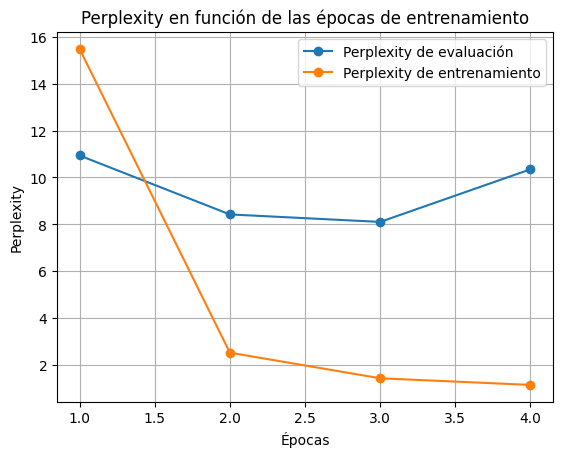

In [ ]:
import matplotlib.pyplot as plt

# Obtener épocas y valores de los tensores
epochs = list(range(1, len(eval_results) + 1))
eval_perplexity_values = [eval_results[key].item() for key in eval_results]
train_perplexity_values = [result.item() for result in train_results]

# Graficar
plt.plot(epochs, eval_perplexity_values, marker='o', label='Perplexity de evaluación')
plt.plot(epochs, train_perplexity_values, marker='o', label='Perplexity de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Perplexity')
plt.title('Perplexity en función de las épocas de entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
eval_perplexity_values

[4.661747932434082, 2.691441297531128, 2.359341859817505, 2.3664474487304688]

## Probamos el modelo

In [25]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPTbarneymedium')
model = AutoModelForCausalLM.from_pretrained('/content/outputbarneymedium')

OSError: microsoft/DialoGPTbarneymedium is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large')
model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-large')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Vamos a tener una conversación de 5 líneas
for step in range(5):
    # Codificar la nueva entrada del usuario, agregar el token de fin de secuencia (eos_token) y devolver un tensor en Pytorch
    new_user_input_ids = tokenizer.encode(input(">> Usuario:") + tokenizer.eos_token, return_tensors='pt')
    # Imprimir los nuevos identificadores de entrada del usuario
    # print(new_user_input_ids)

    # Concatenar los nuevos tokens de entrada del usuario al historial del chat
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # Generar una respuesta limitando el historial total del chat a 1000 tokens
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=80,
        top_p=0.8,
        temperature=0.2
    )

    # Imprimir de manera legible los últimos tokens de salida del bot
    print("Barney: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> Usuario:Hi!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Barney: Hi, Shannon.
>> Usuario:I'm Ted!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Barney: !!!?!!!!?!!!!!!Excuse me, someone has already put on this chair?
>> Usuario:What are you talking about, Barney? 


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Barney: !False!!False,!!
>> Usuario:Do you want a beer?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Barney: !Oh!!Oh,!Oh.!! Hi guys!! My neck!! Uh...!! Hey!! Look at this!! Oh!! Come on!! Now!!Relax!! This is Slash from Guns N'Roses!
>> Usuario:bye barney


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Barney: !!?!?!


## Push Model to Hugging Face

In [21]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [22]:
!git config --global user.email "davidgonveg@gmail.com"
# Tip: using the same email as your huggingface.co account will link your commits to your profile
!git config --global user.name "Dagonez"

In [23]:


#Añadir el token de huggingface de: https://huggingface.co/settings/tokens
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
MY_MODEL_NAME = 'DialoGPT-medium-Barney-Bot'
model.push_to_hub(MY_MODEL_NAME)
tokenizer.push_to_hub(MY_MODEL_NAME)